In [1]:
#import library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import numpy as np
import zipfile, os

In [2]:
# ==========================
# 1. Parameter & Path
# ==========================
IMAGE_SIZE = (224, 224)  
BATCH_SIZE = 32
EPOCHS = 30  
NUM_CLASSES = 3

base_dir = "D:/KULIAH UNDIP/SKRIPSI S NYA SANTUY/DATASET/Dataset New"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [3]:
# ==========================
# 2. Data Augmentation
# ==========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),         
    layers.RandomRotation(0.1),              
    layers.RandomZoom(0.1),                  
    layers.RandomTranslation(0.1, 0.1),     
    layers.RandomContrast(0.1)              
])


In [4]:
# ==========================
# 3. Load Dataset
# ==========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Hanya load test_ds (tanpa val_ds)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2647 files belonging to 3 classes.
Found 1137 files belonging to 3 classes.


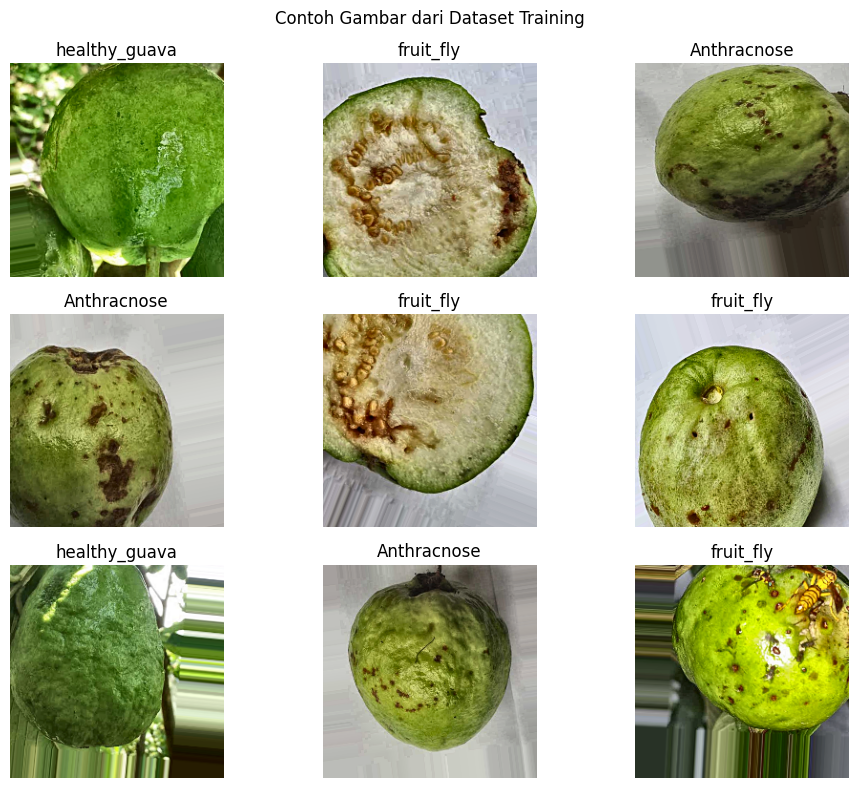

In [5]:
# Visualisasi beberapa gambar dari dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Dataset Training")
plt.tight_layout()
plt.show()

In [6]:
#  4. Model CNN 

model = models.Sequential([
    layers.Input(shape=IMAGE_SIZE + (3,)),
    layers.Rescaling(1./255),  # Normalisasi ke 0-1

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
from tensorflow.keras.optimizers import Adam

LEARNING_RATE = 1e-4

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)


In [8]:
# ==========================
# 5. Class Weights (Optional)
# ==========================
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [9]:
# ==========================
# 7. Callbacks
# ==========================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [10]:
# ==========================
# 8. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=test_ds, 
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.4626 - loss: 1.0136 - precision: 0.5557 - recall: 0.1739 - val_accuracy: 0.6667 - val_loss: 0.6746 - val_precision: 0.7135 - val_recall: 0.4820
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step - accuracy: 0.6904 - loss: 0.6233 - precision: 0.7268 - recall: 0.6000 - val_accuracy: 0.7476 - val_loss: 0.5597 - val_precision: 0.7741 - val_recall: 0.6781
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 353ms/step - accuracy: 0.7765 - loss: 0.4974 - precision: 0.7991 - recall: 0.7318 - val_accuracy: 0.7933 - val_loss: 0.4898 - val_precision: 0.8226 - val_recall: 0.7546
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 359ms/step - accuracy: 0.8294 - loss: 0.4209 - precision: 0.8445 - recall: 0.8053 - val_accuracy: 0.8953 - val_loss: 0.3081 - val_precision: 0.9032 - val_recall: 0.8865
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 356ms/step - accuracy: 0.8741 - loss: 0.3224 - precision: 0.8814 - recall: 0.8625 - val_accuracy: 0.8830 - val_los

In [11]:
# ==========================
# 9. Evaluate
# ==========================
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9779 - loss: 0.0796 - precision: 0.9798 - recall: 0.9771

Test Accuracy: 0.9657
Test Loss: 0.1002
Test Precision: 0.9665
Test Recall: 0.9648


In [12]:
# ==========================
# 10. Classification Report
# ==========================
from sklearn.metrics import classification_report


y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.98      0.98      0.98       464
    fruit_fly       0.98      0.95      0.97       394
healthy_guava       0.92      0.96      0.94       279

     accuracy                           0.97      1137
    macro avg       0.96      0.96      0.96      1137
 weighted avg       0.97      0.97      0.97      1137



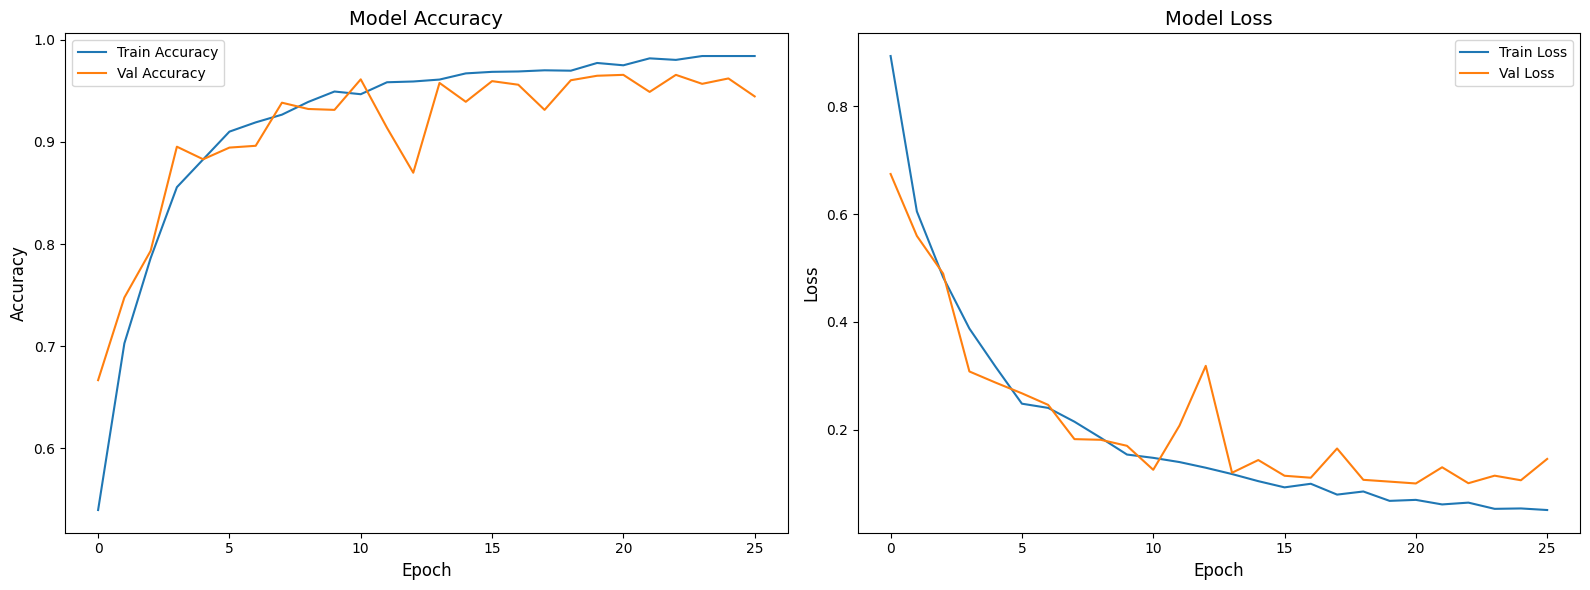

In [13]:
# Plot Accuracy
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()



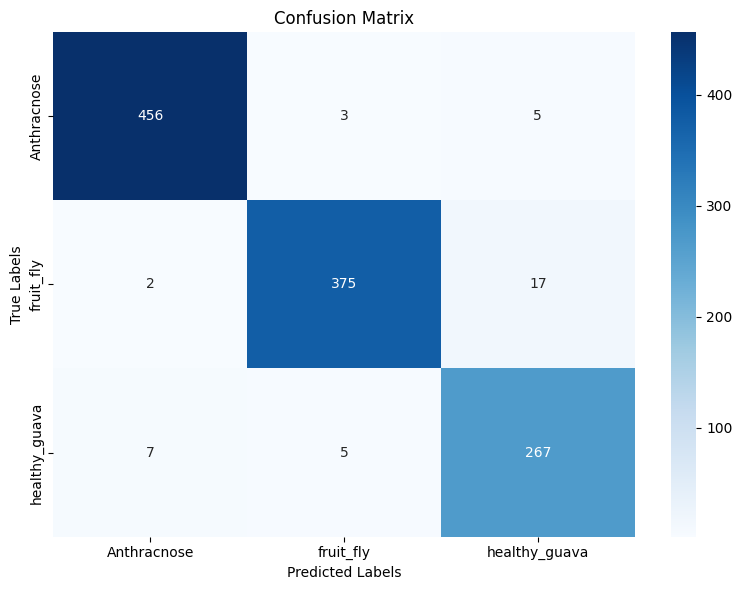

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
# Save model terbaik
model.save("best_model.keras")

# Load model terbaik dari training
model = tf.keras.models.load_model("best_model.keras")

# Konversi ke TFLite (tanpa quantization untuk memastikan tidak rusak)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file
tflite_model_path = r'D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\python\GuavaDisease_CNN_Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model exported to:", tflite_model_path)


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpr7zbdwf0\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpr7zbdwf0\assets


Saved artifact at 'C:\Users\lenovo\AppData\Local\Temp\tmpr7zbdwf0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2256430783888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430778704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430780432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430783696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430779088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430781776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430782736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430784080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2256430781584: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite 